### Klasy bazowe

In [56]:
import abc
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score
import math

In [2]:
class AbstractLayer(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self):
        """Inits the class."""
        super(AbstractLayer, self).__init__()
    
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer."""
        pass


class AbstractModel(tf.keras.Model):
    """Abstract model."""

    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()

    @abc.abstractmethod
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        pass

    @abc.abstractmethod
    def fit(self, **kwargs):
        """Fits the model.

        Replaces original fit method.
        
        More information can be found in documentation:
        https://www.tensorflow.org/guide/eager
        https://www.tensorflow.org/guide/autodiff
        """
        pass

    @abc.abstractmethod
    def predict(self, x):
        """Predicts x"""
        pass

### Instrukcje pomoniczne do wykonania przetwarzania wstępnego


In [3]:
# Wczytanie zbioru danych
dataset_path = 'data/dataset.pkl'

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)

In [4]:
# Ustawienie ziarna
tf.random.set_seed(1234)

In [5]:
def get_data(part):
    images = dataset[part]['X']
    labels = dataset[part]['y']
    
    return images, labels

In [6]:
def images_preprocessing(images):
    # Zmiana rozmiaru obrazu z 224x224 do 64x64
    images = tf.image.resize(
        images, [64, 64], 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
        preserve_aspect_ratio=False,
        name=None
    )
    
    # Spłaszczanie obrazów do jednego wymiaru (np. z 64x64x3 do 12288)
    images = tf.reshape(images, [images.shape[0], -1])
    
    # Zmiana typu obrazów z int na float 
    # i normalizacja wartości pikseli z przedziału 0-255 do przedziału 0-1
    images = tf.cast(images, tf.float32) / 255.0
    
    return images

In [7]:
def labels_preprocessing(labels):
    # Zmiana wymiarowości z [8870] na [8870, 1] 
    # w celu zastosowania `SparseCategoricalCrossentropy`
    labels = tf.reshape(labels, [-1, 1])
    
    return labels

In [8]:
def dataset_to_batches(X, y):
    # Preprocess images
    images = images_preprocessing(X)
    # Preprocess labels
    labels = labels_preprocessing(y)
    
    # Do iterowania zbioru danych i podzielenia na paczki (ang. batch) 
    # można wykorzystać interfejs zdefiniowany w `tensorflow.data.Dataset`
    ds = tf.data.Dataset.from_tensor_slices((images, labels)) 
    ds = ds.shuffle(buffer_size=len(images)).batch(batch_size=100)
    
    return ds

In [9]:
# Wczytanie mechanizmu paczkowania dla zbiorów
train_X, train_y = get_data("train")
train_ds = dataset_to_batches(train_X, train_y)

test_X, test_y = get_data("test")
test_ds = dataset_to_batches(test_X, test_y)

val_X, val_y = get_data("validation")
val_ds = dataset_to_batches(val_X, val_y)

### Model

In [28]:
class BaseLayer(AbstractLayer):
    def __init__(self, units, inputs, activation_func):
        super(BaseLayer, self).__init__()
        
        self.units = units
        self.activation_func = activation_func

        self.weights_ = self.add_weight(shape=(inputs, units), 
                                 initializer="random_uniform")
        self.bias = self.add_weight(shape=(units,), 
                                 initializer="random_uniform")
        
        
    def call(self, inputs):
        # Podanie do przodu
        z = tf.matmul(inputs, self.weights_) + self.bias
        return self.activation_func(z)

    
class BaseModel(AbstractModel):
    def __init__(self): 
        super(BaseModel, self).__init__()
        
        self.first_layer = BaseLayer(units = 256, 
                                     inputs = 12288, 
                                     activation_func = tf.keras.activations.relu)
        self.second_layer = BaseLayer(units = 14, 
                                      inputs = 256, 
                                      activation_func = tf.keras.activations.softmax)

        
    def call(self, inputs, training=False):
        # Podanie do przodu przez całą sieć
        first_layer_out = self.first_layer(inputs)
        second_layer_out = self.second_layer(first_layer_out)
        
        return second_layer_out

    
    def fit(self, **kwargs):
        self.train_loss_list = []
        self.train_f1_list = []
        
        self.test_loss_list = []
        self.test_f1_list = []
        
        self.val_loss_list = []
        self.val_f1_list = []
        
        ds_train = kwargs.get("ds_train", train_ds)
        ds_test = kwargs.get("ds_test", test_ds)
        ds_val = kwargs.get("ds_val", val_ds)
        
        batch_size = kwargs.get("batch_size", 100)
        learning_rate = kwargs.get("learning_rate", 0.001)
        optimizer = kwargs.get("optimizer", tf.keras.optimizers.Adam)
        optimizer = optimizer(learning_rate=learning_rate)
        epochs = kwargs.get("epochs", 25)
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())
        
        for epoch in range(epochs):        
            f1 = tfa.metrics.F1Score(num_classes=14, average="macro")
            
            for X, y in train_ds:
                with tf.GradientTape() as tape:
                    logits = self.call(X)
                    loss = cost_func(y, logits)
                    
                grads = tape.gradient(loss, self.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))
                
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.train_loss_list.append(loss)
                self.train_f1_list.append(f1.result())
            
            print('TRAINING: Epoch: %d  -  loss: %.3f; F1_score: %.3f'%(epoch, 
                                                                        self.train_loss_list[-1], 
                                                                        self.train_f1_list[-1]))
            
            for X, y in ds_test:
                logits = self.call(X)
                loss = cost_func(y, logits)
                
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.test_loss_list.append(loss)
                self.test_f1_list.append(f1.result())
            
            print('TEST: Epoch: %d  -  loss: %.3f; F1_score: %.3f'%(epoch, 
                                                                    self.test_loss_list[-1], 
                                                                    self.test_f1_list[-1]))
            
            for X, y in ds_val:
                logits = self.call(X)
                loss = cost_func(y, logits)
                
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.val_loss_list.append(loss)
                self.val_f1_list.append(f1.result())
            
            print('VALIDATION: Epoch: %d  -  loss: %.3f; F1_score: %.3f'%(epoch, 
                                                                          self.val_loss_list[-1], 
                                                                          self.val_f1_list[-1]))
    

    def predict(self, X):
        logits = self.call(X)
        pred = tf.argmax(logits, axis=1)
        
        return pred

In [29]:
# Zbiór szkoleniowy
ds_train = train_ds

# Zbiór testowy
ds_test = test_ds

# Zbiór walidacyjny
ds_val = val_ds

# Wielkość paczki: 100
batch_size = 100

# Współczynnik uczenia: 0.001
learning_rate = 0.001

# Optymalizator: Adam
optimizer = tf.keras.optimizers.Adam

# Liczba epok: 25
epochs = 25

# Funkcja kosztu: tf.keras.losses.SparseCategoricalCrossentropy
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()


model = BaseModel()

model.fit(ds_train=ds_train,
          ds_test=ds_test,
          ds_val=ds_val,
          batch_size=batch_size, 
          learning_rate=learning_rate, 
          optimizer=optimizer,
          epochs=epochs, 
          cost_func=cost_func)

TRAINING: Epoch: 0  -  loss: 2.480; F1_score: 0.066
TEST: Epoch: 0  -  loss: 2.594; F1_score: 0.076
VALIDATION: Epoch: 0  -  loss: 2.591; F1_score: 0.078
TRAINING: Epoch: 1  -  loss: 2.389; F1_score: 0.104
TEST: Epoch: 1  -  loss: 2.465; F1_score: 0.101
VALIDATION: Epoch: 1  -  loss: 2.519; F1_score: 0.097
TRAINING: Epoch: 2  -  loss: 2.512; F1_score: 0.121
TEST: Epoch: 2  -  loss: 2.504; F1_score: 0.125
VALIDATION: Epoch: 2  -  loss: 2.350; F1_score: 0.127
TRAINING: Epoch: 3  -  loss: 2.316; F1_score: 0.149
TEST: Epoch: 3  -  loss: 2.452; F1_score: 0.146
VALIDATION: Epoch: 3  -  loss: 2.359; F1_score: 0.145
TRAINING: Epoch: 4  -  loss: 2.297; F1_score: 0.166
TEST: Epoch: 4  -  loss: 2.389; F1_score: 0.160
VALIDATION: Epoch: 4  -  loss: 2.597; F1_score: 0.155
TRAINING: Epoch: 5  -  loss: 2.352; F1_score: 0.171
TEST: Epoch: 5  -  loss: 2.559; F1_score: 0.167
VALIDATION: Epoch: 5  -  loss: 2.343; F1_score: 0.162
TRAINING: Epoch: 6  -  loss: 2.356; F1_score: 0.181
TEST: Epoch: 6  -  loss:

In [67]:
def plot_results(list_to_plot, title, xlab, ylab):
    arr = np.asarray(list_to_plot)
    arr = np.mean(arr.reshape(-1, el_per_batch), axis=1)
    
    plt.plot(arr)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)

#### training dataset

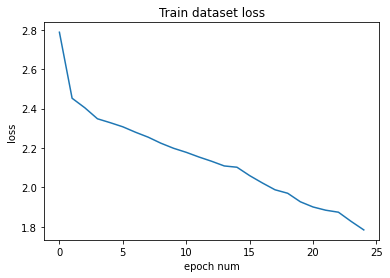

In [60]:
el_per_batch = math.ceil(len(train_X) / batch_size)

plot_results(list_to_plot=model.train_loss_list, 
             title='Train dataset loss', 
             xlab='epoch num', 
             ylab='loss')

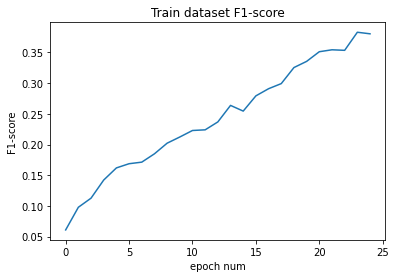

In [61]:
plot_results(list_to_plot=model.train_f1_list, 
             title='Train dataset F1-score', 
             xlab='epoch num', 
             ylab='F1-score')

#### test dataset

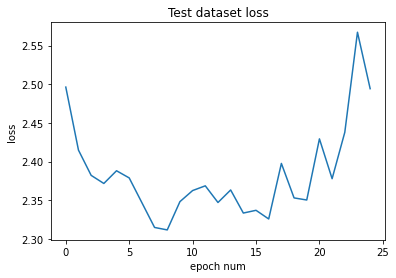

In [62]:
el_per_batch = math.ceil(len(test_X) / batch_size)

plot_results(list_to_plot=model.test_loss_list, 
             title='Test dataset loss', 
             xlab='epoch num', 
             ylab='loss')

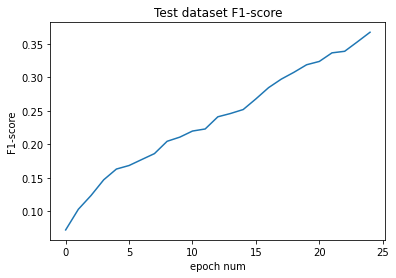

In [63]:
plot_results(list_to_plot=model.test_f1_list, 
             title='Test dataset F1-score', 
             xlab='epoch num', 
             ylab='F1-score')

In [38]:
test_X, test_y = get_data("test")
test_X = images_preprocessing(test_X)
test_y = labels_preprocessing(test_y)

y_pred = model.predict(test_X)
f1 = f1_score(test_y, y_pred, average='micro')

f1

0.23027646662171275

#### validation dataset

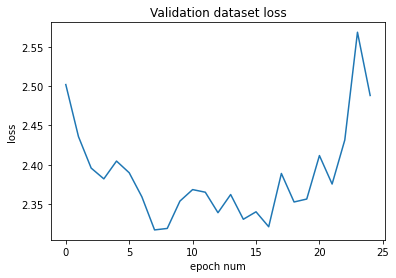

In [65]:
el_per_batch = math.ceil(len(val_X) / batch_size)

plot_results(list_to_plot=model.val_loss_list, 
             title='Validation dataset loss', 
             xlab='epoch num', 
             ylab='loss')

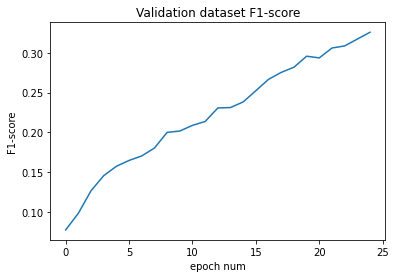

In [66]:
plot_results(list_to_plot=model.val_f1_list, 
             title='Validation dataset F1-score', 
             xlab='epoch num', 
             ylab='F1-score')

#### confusion matrix

In [85]:
classes = list(dataset['labels_mapping'].keys())

classes

['indo-islamic',
 'chinese',
 'art_deco',
 'secession',
 'romanesque',
 'byzantine',
 'russian_revival',
 'victorian_quenn_anne',
 'neoclassical',
 'postmodernism',
 'baroque',
 'achaemenid',
 'ancient',
 'renaissance']

In [107]:
for cls_k, cls_v in dataset['labels_mapping'].items():
    print(cls_k, '-', np.count_nonzero(dataset['test']['y'] == cls_v))

indo-islamic - 161
chinese - 157
art_deco - 175
secession - 173
romanesque - 248
byzantine - 131
russian_revival - 165
victorian_quenn_anne - 325
neoclassical - 234
postmodernism - 158
baroque - 498
achaemenid - 131
ancient - 191
renaissance - 219


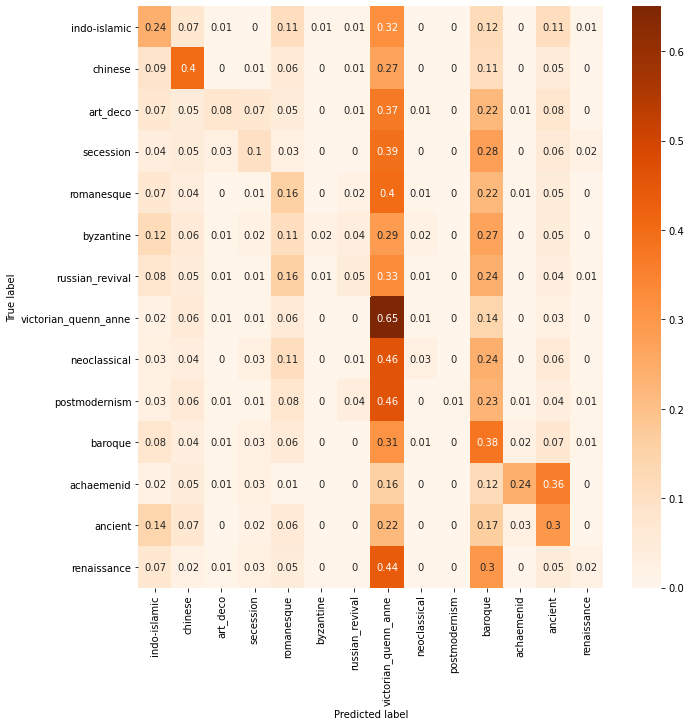

In [88]:
test_X, test_y = get_data("test")
test_X = images_preprocessing(test_X)
test_y = labels_preprocessing(test_y)

y_pred = model.predict(test_X)

con_mat = tf.math.confusion_matrix(labels=test_y, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = classes, 
                          columns = classes)

figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Oranges)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [21]:
def display_image_with_pred(image, pred_class):
    plt.imshow(image)
    title = 'Pred class: ' + str(pred_class)
    plt.title(title)
    plt.show()

===== REAL CLASS: indo-islamic =====


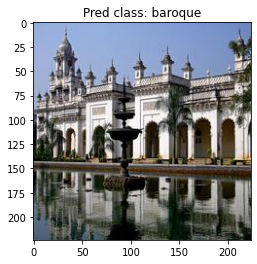

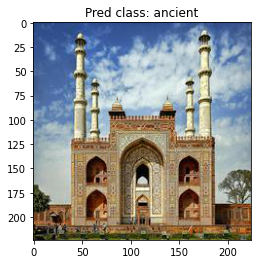

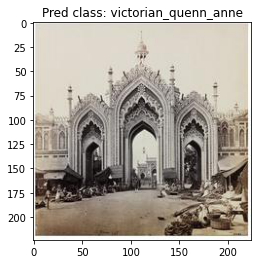

===== REAL CLASS: chinese =====


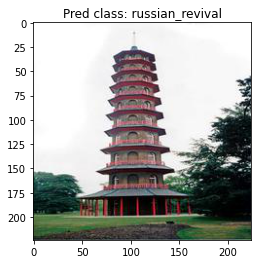

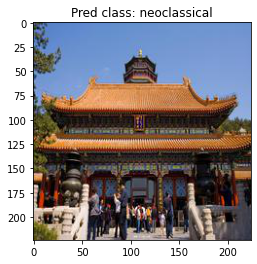

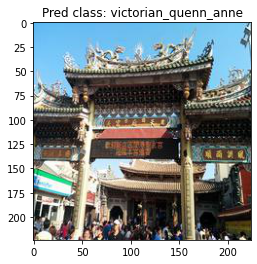

===== REAL CLASS: art_deco =====


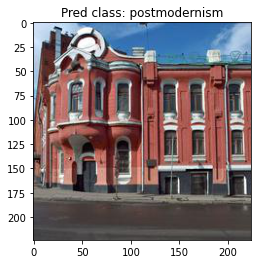

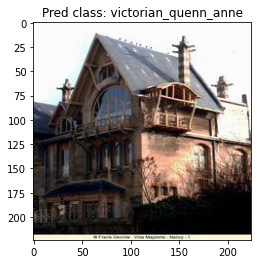

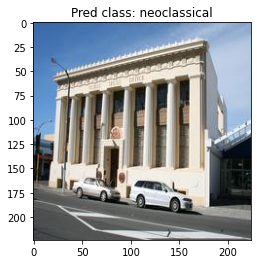

===== REAL CLASS: secession =====


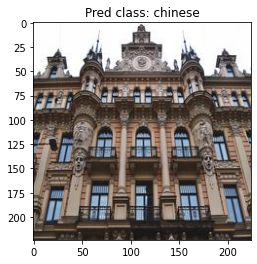

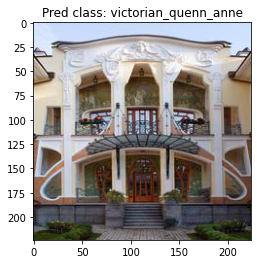

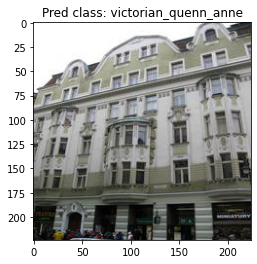

===== REAL CLASS: romanesque =====


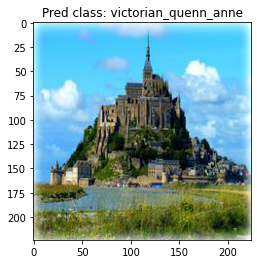

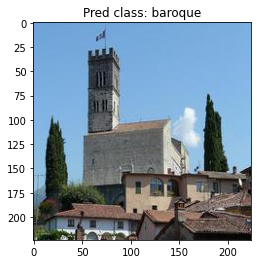

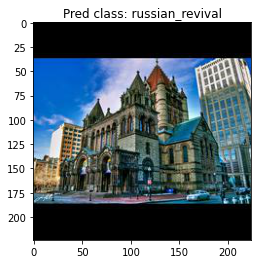

===== REAL CLASS: byzantine =====


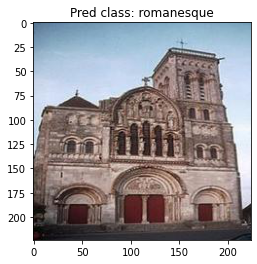

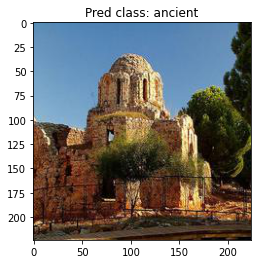

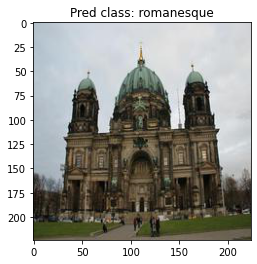

===== REAL CLASS: russian_revival =====


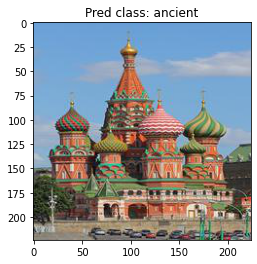

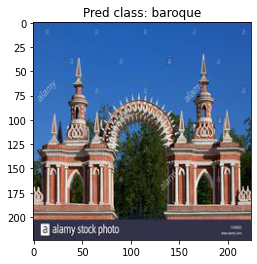

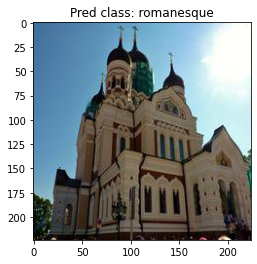

===== REAL CLASS: victorian_quenn_anne =====


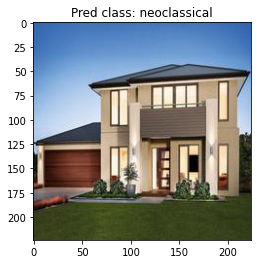

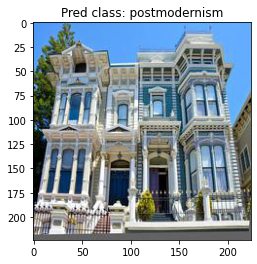

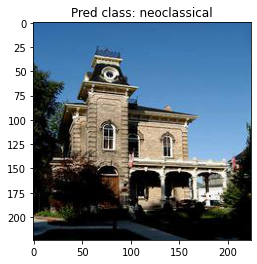

===== REAL CLASS: neoclassical =====


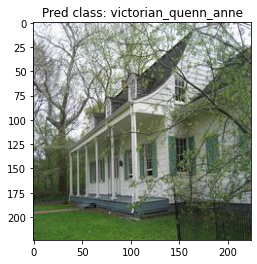

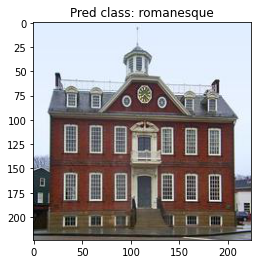

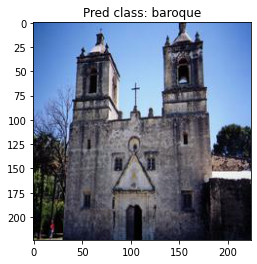

===== REAL CLASS: postmodernism =====


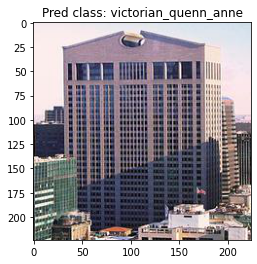

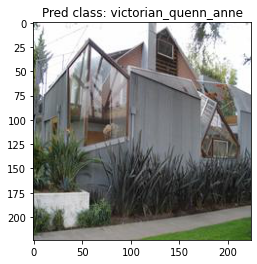

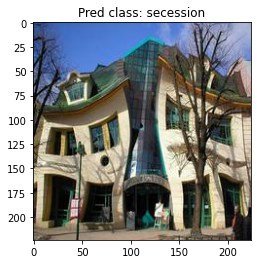

===== REAL CLASS: baroque =====


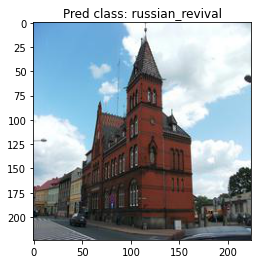

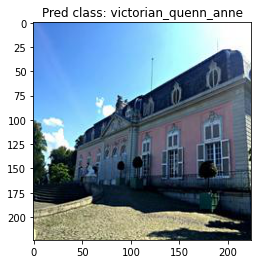

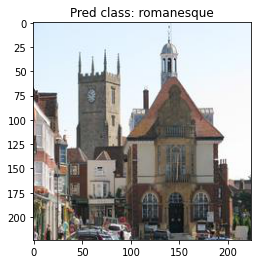

===== REAL CLASS: achaemenid =====


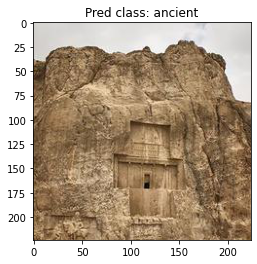

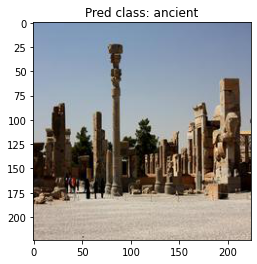

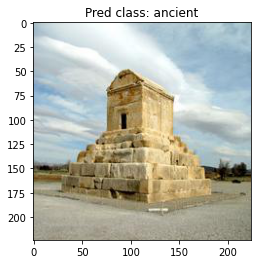

===== REAL CLASS: ancient =====


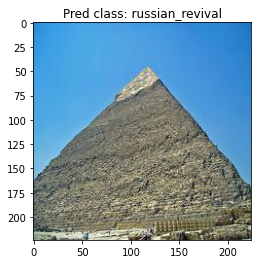

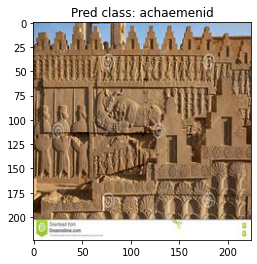

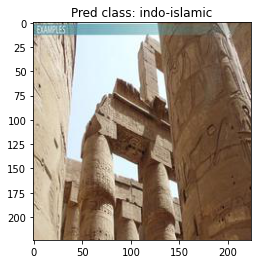

===== REAL CLASS: renaissance =====


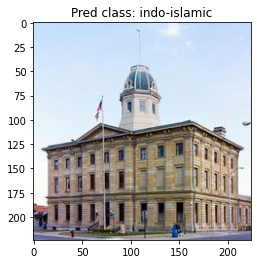

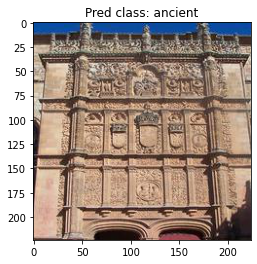

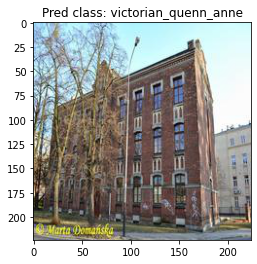

In [22]:
NUM_OF_INCORRRECT_PER_CLASS = 3

test_X, test_y = get_data("test")
test_y = labels_preprocessing(test_y)

for class_num in range(len(classes)):
    print('===== REAL CLASS:', classes[class_num], '=====')
    
    cnt = NUM_OF_INCORRRECT_PER_CLASS
    for image, label, pred in zip(test_X, test_y, y_pred):
        if label.numpy()[0] == class_num:
            if pred != label and cnt > 0:
                display_image_with_pred(image, classes[pred])
                cnt -= 1

### Podsumowanie
- Dokonano przetwarzania wstępnego zbioru danych, następnie wykorzystując klasę bazową BaseLayer zaimplementowano warstwę w pełni połączoną.
- Wykorzystując klasę bazową BaseModel i zaimplementowaną wcześniej warstwę w pełni połączoną, zdefiniowano architekturę sieci, funkcję uczenia sieci i funkcję ewaluacji modelu. 
    - Ewaluacja modelu obejmuje metrykę F1 oraz logowanie wartości funkcji straty
- Zwizualizowano otrzymane rezultaty:
    - Przedstawiono wartości metryki F1 w zależności od epoki (dla zbioru treningowego, walidacyjnego i testowego)
    - Przedstawiono krzywą funkcji kosztu w zależności od epoki (dla zbioru treningowego, walidacyjnego i testowego)
    - Przedstawiono macierz pomyłek (confusion matrix) dla zbioru testowego
- Zwizualizowano kilka przykładów na klasę, dla których model podejmował złą decyzję

### Wnioski
- Jakość modelu pozostawia wiele do życzenia.
- Uzyskano wartość F1-score dla zbioru testowego na poziomie 0.2303.